<a href="https://colab.research.google.com/github/lauraceciliadiazdavila/IA-LIDeSIA-Dpto-Computacion/blob/main/14.Transformers/2025_2_Fine_tuning_con_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

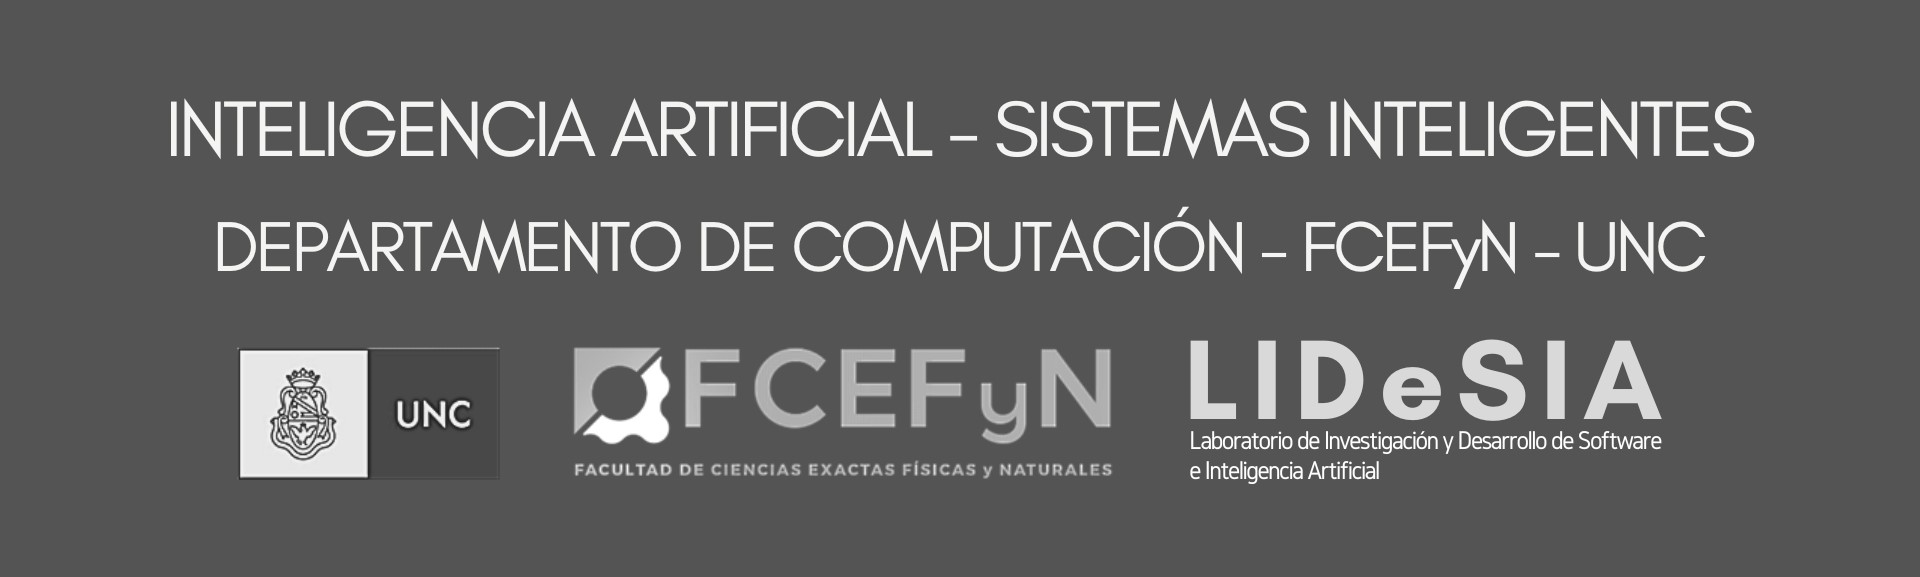


# BERT: Bidirectional Encoder Representations from Transformers
---

FCEFyN - UNC - Cátedra de Inteligencia Artificial

---

*   Autor/es: Mgtr. Ing. Mauro Furer

*   Directora: Dra. Laura Cecilia Diaz Davila (LIDeSIA - FCEFyN)


Adaptado del notebook transformers_v2024.ipynb del Ing. Sandro Comerci.

---




# Introducción a Transformers y BERT

Los modelos de Transformers revolucionaron el procesamiento del lenguaje natural (NLP) debido a su capacidad de capturar relaciones complejas en secuencias de palabras mediante el mecanismo de **autoatención**.
BERT, o **Bidirectional Encoder Representations from Transformers**, es uno de los modelos más destacados que utiliza esta arquitectura.




# Arquitectura Transformer y BERT

Bert se presenta dos configuración:

| Modelo | Capas (L) | Hidden size (H) | Cabezas (A) | FFN size | Parámetros aprox. |
|:--------|:-----------:|:----------------:|:-------------:|:------------:|:----------------:|
| **BERT Base** | 12 encoders | 768 | 12 | 3072 | 110 M |
| **BERT Large** | 24 encoders | 1024 | 16 | 4096 | 340 M |

Dado el modelo transformer [Vaswani et al. (2017)] como arquitectura general podemos describir BERT con las siguiente particularidades,

### 1. Encoder y Decoder (no aplicable a BERT)

La arquitectura de los transformers se compone de dos partes principales: el **encoder** y el **decoder**. Sin embargo, las diferentes familias no se diseñan con ambos componentes necesariamente. Para el ejemplo abordado solo cuenta con Encoder, mientras que el de GPT (Transformes preentrenado generativo) cuenta con el componente decoder solamente.
- El **encoder** convierte una secuencia de entrada en una representación interna mediante múltiples capas de autoatención y capas de feed-forward.
- El **decoder** utiliza esta representación para generar una salida paso a paso. En el caso de BERT, solo se usa el encoder ya que está diseñado para comprender el contexto bidireccional, ideal para tareas de clasificación, análisis de sentimientos, y extracción de entidades.

### 2. Mecanismo de Autoatención

La autoatención permite que cada palabra en una oración se relacione con otras palabras de esa misma oración.
Esto es crucial para que BERT capture tanto el contexto izquierdo como el derecho de una palabra simultáneamente. La autoatención se representa en múltiples matrices llamadas "attention heads".
En cada "head", se calcula la relación de cada palabra con otras palabras de la oración, asignando pesos de importancia a estas relaciones.

### 3. Representación mediante Embeddings

Las palabras deben transformarse en vectores para ser procesadas por el modelo. En BERT, la tokenización descompone el texto en subpalabras con WordPiece, añade tokens especiales `[CLS]` y `[SEP]`:
- `[CLS]`: se coloca al inicio de cada oración y su representación final contiene el contexto completo de la oración
- `[SEP]`: sirve para separar oraciones.
Mapeando cada subunidad a IDs del vocabulario.

El input embedding se representa a través de tres embeddings:
- **Embeddings de token**: la representación vectorial de cada token.
- **Embeddings de segmentación**: utilizados para diferenciar dos oraciones en tareas como respuesta a preguntas.
- **Embeddings de posición**: ayuda a mantener el orden de las palabras dentro de la oración.


A continuación, se muestra una figura con la representación de la entrada para el modelo BERT:


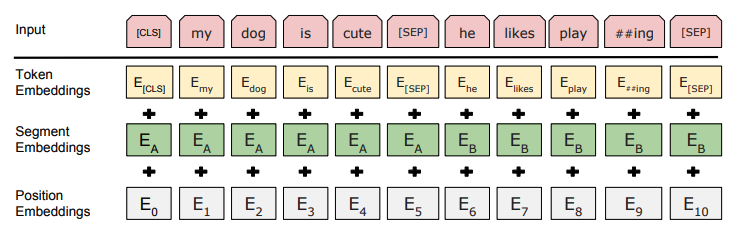

## Fine-Tuning de BERT

Una vez que BERT ha sido **preentrenado** en tareas generales del lenguaje —predecir palabras ocultas (*Masked Language Modeling*)  
y decidir si una oración sigue a otra (*Next Sentence Prediction*)—, el modelo adquiere un conocimiento profundo y bidireccional  
de cómo se estructura y se usa el lenguaje.

 BERT fue preentrenado utilizando un corpus combinado compuesto por **BooksCorpus** (800 millones de palabras) y **Wikipedia en inglés** (2.500 millones de palabras). De Wikipedia se extrajeron únicamente los pasajes de texto, omitiendo listas, tablas y encabezados. Es fundamental emplear un **corpus a nivel de documento**, y no uno con oraciones mezcladas aleatoriamente (como el *Billion Word Benchmark*), para permitir que el modelo aprenda dependencias largas y secuencias coherentes dentro del texto.


El **fine-tuning** es el paso donde ese conocimiento general se **ajusta a una tarea específica**.  
La idea central es que **no es necesario rediseñar el modelo ni cambiar su arquitectura interna**:  
simplemente se **agrega una capa final adicional** (por ejemplo, una capa *softmax* para clasificación)  
y se entrena el modelo completo, incluyendo todas las capas de BERT, con un conjunto de datos supervisado de la tarea deseada.

---

### Adaptabilidad

El fine-tuning convierte a BERT en un modelo adaptable:  
- El modelo preentrenado **ya entiende la gramática y el significado del lenguaje**.  
- En el fine-tuning, ese conocimiento se **especializa** para una tarea concreta, como:  
  - clasificar una oración como positiva o negativa,  
  - responder una pregunta,  
  - o etiquetar entidades en un texto.

En esta etapa, **las representaciones internas de BERT se ajustan ligeramente**,  
de modo que el modelo aprende las “particularidades” del nuevo problema  
sin perder su entendimiento general del lenguaje.

---

### Resumen de los pasos de Fine-Tuning

El proceso de fine-tuning se puede resumir así:

* 1)  Tomar el modelo BERT preentrenado.  
* 2)  Incorporar una capa de salida adaptada a la tarea (por ejemplo, clasificación o predicción).  
* 3)  Entrenar el modelo completo de forma supervisada, con un *learning rate* bajo.  
* 4)  Usar el token **[CLS]** (que representa la oración entera) o los embeddings por token, según el tipo de tarea.






# Fine Tuning de BERT para tareas de clasificacion

A continuación, se muestra un ejemplo práctico de cómo utilizar BERT para tareas de procesamiento del lenguaje natural. En este caso una tarea de clasificación binaria de reseñas de películas. Donde dada una reseña vamos a predecir si es positiva o negativa.

# Instalacion de libreria para el uso de transformers

In [ ]:
# Ejemplo de código BERT
!pip install transformers

## Descarga del Dataset


Vamos a descargar un dataset de películas donde tenemos reseñas de cada una de ellas y también una etiqueta con la valoracion de la película, la misma es de caracter binario: positiva o negativa.

In [ ]:
# Ejemplo de código BERT
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

# Descargar el conjunto de datos de mensajes de reviews de peliculas
nltk.download('movie_reviews')

# Obtener las reseñas de películas
messages = []
labels = []

for category in movie_reviews.categories():
    for file_id in movie_reviews.fileids(category):
        words = movie_reviews.words(file_id)
        message = ' '.join(words)
        messages.append(message)
        labels.append(category)

# Visualizar algunas reseñas
for i in range(3):
    print(f"Mensaje: {messages[i]}")
    print(f"Etiqueta: {labels[i]}\n")

# División del Dataset para Train y Test

Se divide el dataset de reseñas de películas en un conjunto para el Training y otro conjunto para el testing.

In [ ]:
# Ejemplo de código BERT
# Dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(messages, labels, test_size=0.2, random_state=42)

# Asignar etiquetas numéricas a la valoración
y_train = [1 if label == 'pos' else 0 for label in y_train]
y_test = [1 if label == 'pos' else 0 for label in y_test]

# Verificar la cantidad de ejemplos en entrenamiento y prueba
print(f"Ejemplos de entrenamiento: {len(X_train)}")
print(f"Ejemplos de prueba: {len(X_test)}")

#Cargar el Tokenizador BERT:

Se carga el tokenizador BERT preentrenado 'bert-base-uncased' utilizando BertTokenizer.from_pretrained('bert-base-uncased'). Este tokenizador se utiliza para dividir el texto de las reseñas en tokens que BERT pueda comprender.

In [ ]:
# Ejemplo de código BERT
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch

MODEL_NAME = "bert-base-uncased"

# Cargar el tokenizador BERT
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

**Tokenización de los Mensajes y Creación de Entradas BERT:**

Se define una función tokenize_data que toma una lista de mensajes y etiquetas como entrada. La función realiza lo siguiente:
Itera a través de cada mensaje y su etiqueta en los datos de entrenamiento o prueba.
Utiliza el tokenizador BERT para codificar el mensaje. Esto incluye agregar tokens especiales, limitar la longitud a 128 tokens, agregar máscaras de atención y realizar truncamiento si es necesario.
Almacena los input_ids (identificadores de tokens), las máscaras de atención y las etiquetas en listas separadas (input_ids, attention_masks, new_labels).
Finalmente, convierte estas listas en tensores PyTorch.

In [ ]:
# Ejemplo de código BERT
# Tokenizar los mensajes y convertirlos en entradas BERT
def tokenize_data(messages, labels):
    input_ids = []
    attention_masks = []
    new_labels = []

    for message, label in zip(messages, labels):
        encoded_dict = tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        new_labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(new_labels)

    return TensorDataset(input_ids, attention_masks, labels)

train_data = tokenize_data(X_train, y_train)
test_data = tokenize_data(X_test, y_test)

# Verificar las dimensiones de los datos
print(f"Dimensiones de datos de entrenamiento: {train_data.tensors[0].shape}")
print(f"Dimensiones de datos de prueba: {test_data.tensors[0].shape}")

El modelo BERT (Bidirectional Encoder Representations from Transformers) necesita dos tipos de entradas:



1.   Input IDs (identificadores de tokens): Estos son identificadores únicos para
cada token en el texto. Cada token en el texto se asigna a un identificador numérico específico. BERT utiliza un vocabulario de tokens preentrenado, y cada palabra o subpalabra del texto se mapea a un identificador en ese vocabulario. Los input IDs son una secuencia de estos identificadores que representan el texto de entrada. Además, se suelen agregar tokens especiales al principio y al final de la secuencia (CLS y SEP) para indicar el comienzo y el final de la entrada.

2.   Attention Masks (máscaras de atención): Las máscaras de atención indican cuáles tokens son relevantes y cuáles son relleno. Para las palabras reales del texto, la máscara de atención tiene el valor 1, mientras que para los tokens de relleno (que se agregan para que todas las secuencias tengan la misma longitud), la máscara de atención tiene el valor 0. Esto permite al modelo BERT ignorar los tokens de relleno y centrarse en los tokens importantes del texto.





In [ ]:
# Ejemplo de código BERT
# Elegir un índice de secuencia específico (por ejemplo, 0 para la primera secuencia)
sequence_index = 101

# Obtener los identificadores de tokens y las máscaras de atención para la secuencia seleccionada
selected_input_ids = train_data.tensors[0][sequence_index]
selected_attention_mask = train_data.tensors[1][sequence_index]

# Convertir los identificadores de tokens a tokens reales utilizando el tokenizador
decoded_tokens = tokenizer.convert_ids_to_tokens(selected_input_ids)

# Imprimir los tokens y las máscaras de atención
print(f"Tokens : {decoded_tokens}")
print(f"Máscara de Atención: {selected_attention_mask}")

# Fine-Tuning de modelo BERT:

Inicialmente se instancia un modelo BERT, el cual fue preentrenado para la clasificación de secuencias utilizando BertForSequenceClassification. En este caso, se utiliza el modelo base "bert-base-uncased". El modelo se inicializa con el número de etiquetas de clasificación, que en este ejemplo es 2 (clasificación binaria).

In [ ]:
# Ejemplo de código BERT
from transformers import BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch import nn

# Definir el dispositivo (GPU si está disponible, de lo contrario, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear un modelo BERT preentrenado para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Cargar el modelo en el dispositivo
model.to(device)

# Crear un DataLoader para los datos de entrenamiento y prueba
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

# Fine-tuning del modelo
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
epochs = 4

for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        #Realizamos una pasada hacia adelante (forward pass)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        logits = outputs.logits

        #Extraemos la pérdida (loss) del objeto outputs. La pérdida representa qué tan bien se están haciendo las predicciones del modelo en comparación con las etiquetas reales.
        loss = loss_fn(logits, labels)

        #Realizamos una pasada hacia atrás (backward pass) para calcular los gradientes de la pérdida con respecto a los parámetros del modelo
        loss.backward()

        #Calculamos los gradientes, se utilizan para ajustar los pesos (parámetros) del modelo
        optimizer.step()

        #Antes de procesar el siguiente lote de datos, se reinician los gradientes a cero para evitar acumulaciones
        optimizer.zero_grad()

# Evaluación del modelo BERT luego del fine-tuning

In [ ]:
# Ejemplo de código BERT
from sklearn.metrics import accuracy_score, classification_report

model.eval()
y_true = []
y_pred = []

for batch in tqdm(test_dataloader):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad(): #Esta línea indica que las operaciones dentro de este bloque de código no deben realizar un seguimiento de los gradientes. Esto significa que cualquier cálculo realizado aquí no afectará los parámetros del modelo, lo que es útil cuando se realizan predicciones y no se necesita ajustar los pesos.

        #Pasada hacia adelante
        outputs = model(input_ids, attention_mask=attention_mask)

        #Se extraen las salidas sin procesar del modelo
        logits = outputs.logits

        #Clase con valor mas alto
        predicted_labels = torch.argmax(logits, dim=1)

        y_pred.extend(predicted_labels.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calcular la precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión en el conjunto de prueba: {accuracy:.2f}')

# Generar informe de clasificación
class_names = ['neg', 'pos']
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print('Informe de clasificación:')
print(classification_rep)

# Ejemplos de clasificación

In [ ]:
# ✅ Reseñas de prueba (2 positivas, 2 negativas)
reviews = [
    # Positive
    "The movie was absolutely amazing, with outstanding performances and a beautiful story.",
    "A brilliant film — the visuals were stunning and the script was very well written.",

    # Negative
    "The plot was messy, the acting was terrible, and I couldn't wait for it to end.",
    "A boring and predictable movie with no real emotion or originality."
]

# Tokenizar todas las reseñas
encodings = tokenizer(
    reviews,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# Enviar a GPU o CPU
inputs = {k: v.to(device) for k, v in encodings.items()}

# Obtener predicciones
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label_ids = torch.argmax(logits, dim=1).cpu().numpy()

# Etiquetas de clase (según tu modelo)
class_names = ['neg', 'pos']

# Mostrar resultados
for text, label_id in zip(reviews, predicted_label_ids):
    print(f"🎬 Reseña: {text}")
    print(f"→ Predicción: {class_names[label_id]}")
    print("—" * 80)


# Monta el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Guarda modelo en drive

In [ ]:
# Ruta donde se guardará el modelo
output_dir = "/content/drive/MyDrive/bert_finetuned"

# Guardar el modelo y el tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Modelo guardado en: {output_dir}")


# Carga de modelo desde archivo

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "/content/drive/MyDrive/bert_finetuned"

# Cargar modelo y tokenizer desde Drive
model_ft = BertForSequenceClassification.from_pretrained(model_path)
tokenizer_ft = BertTokenizer.from_pretrained(model_path)

# Enviar a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
model_ft.eval()

print("Modelo y tokenizer cargados correctamente.")


# Ejemplo de predicción con el modelo guardado

In [ ]:
review = "The movie was outstanding and full of emotion."

inputs = tokenizer(
    review,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

labels = ['negative', 'positive']
print(f"Predicción: {labels[prediction]}")



# Conclusión y Referencias

En esta notebook, exploramos cómo funcionan los transformers y el modelo BERT en tareas de NLP.
Hemos visto cómo aplicar BERT para tareas prácticas y comprender su salida.

Para una mayor comprensión de BERT y transformers, considera revisar los siguientes materiales:
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (Devlin et al., 2019)](https://arxiv.org/abs/1810.04805)
- [Attention is All You Need (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762)
- Recursos y guías en [Hugging Face](https://huggingface.co/transformers/)

Estos recursos ofrecen una explicación más profunda sobre el modelo y sus aplicaciones.
